## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images

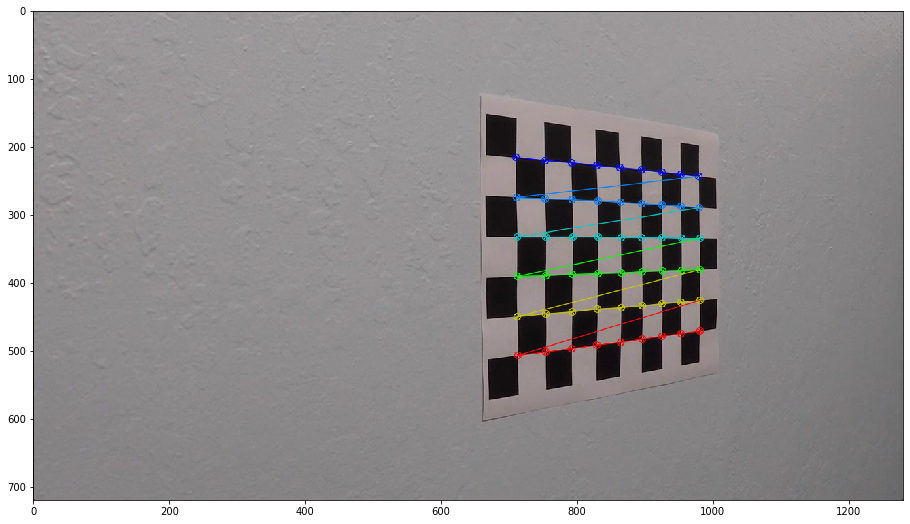

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)

# cv2.destroyAllWindows()
plt.figure(figsize=(16, 9))
plt.imshow(img)

In [2]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

## Apply a distortion correction to raw images.

Text(0.5, 1, 'Undistorted Image')

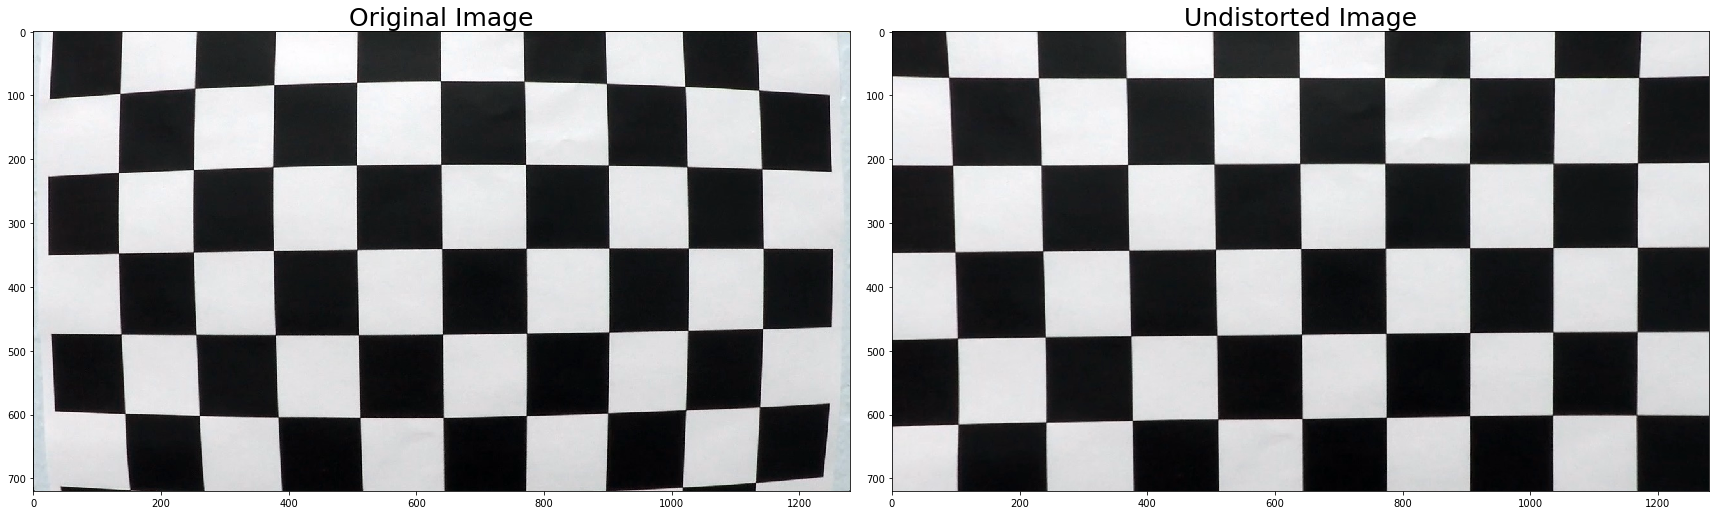

In [3]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

img = cv2.imread('./camera_cal/calibration1.jpg')
undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=25)

True

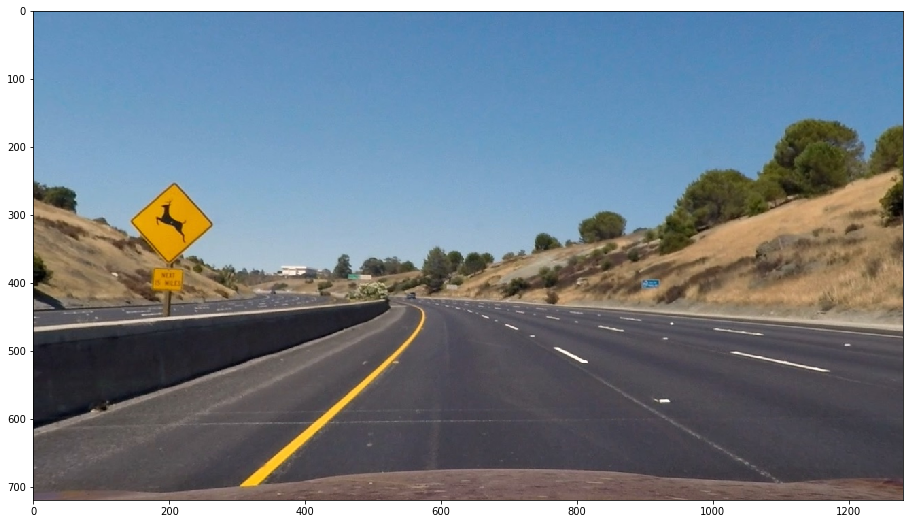

In [4]:
img = cv2.imread('./test_images/test2.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
plt.figure(figsize=(16, 9))
plt.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
cv2.imwrite('./output_images/2_road_undistorted.jpg', undistorted)

## Use color transforms, gradients, etc., to create a thresholded binary image.

In [5]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

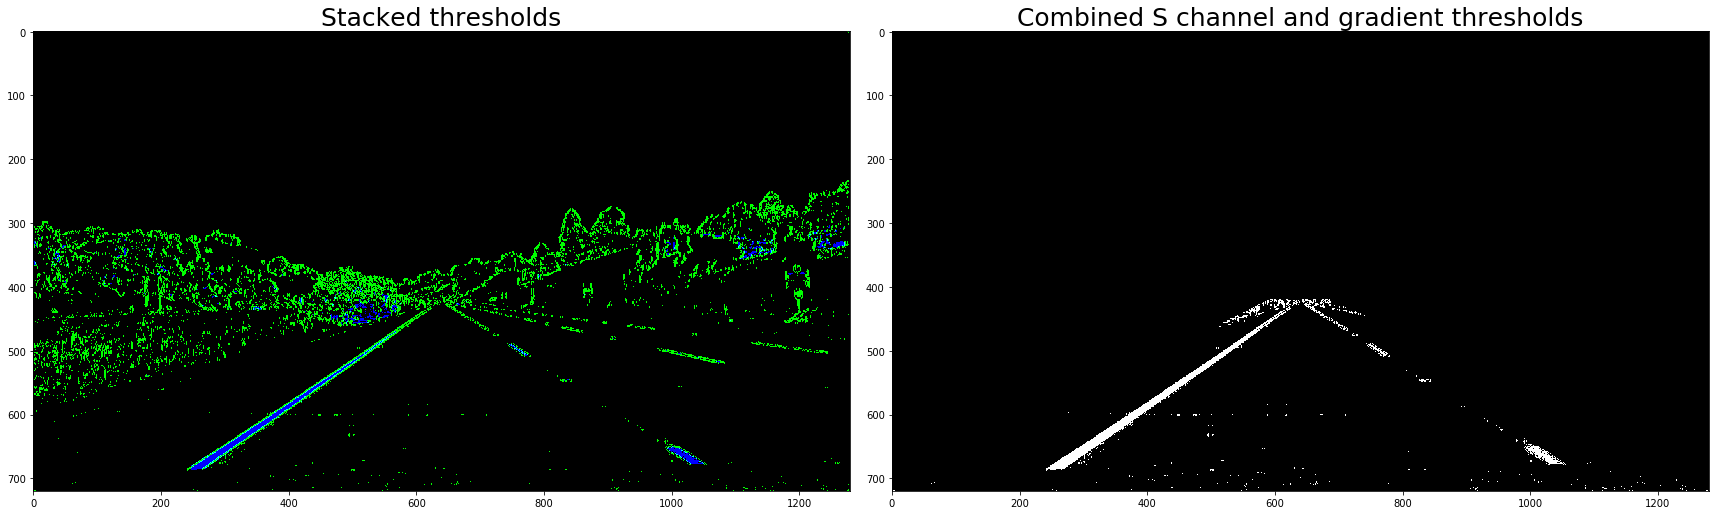

In [6]:
def create_thresholded_binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 175
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    # Get mask roi
    img_size = (combined_binary.shape[1], combined_binary.shape[0]) # grab the image shape
    vertices = np.array([[(0, img_size[1]), 
                          (img_size[0] // 2 - 50, img_size[1] // 2 + 60), 
                          (img_size[0] // 2 + 50, img_size[1] // 2 + 60),
                          (img_size[0], img_size[1])]], dtype=np.int32)
    combined_binary = region_of_interest(combined_binary, vertices)
    
    return color_binary, combined_binary

img = cv2.imread('./test_images/straight_lines1.jpg')
color_binary, combined_binary = create_thresholded_binary(img)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
f.tight_layout()
ax1.set_title('Stacked thresholds', fontsize=25)
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds', fontsize=25)
ax2.imshow(combined_binary, cmap='gray')

## Apply a perspective transform to rectify binary image ("birds-eye view").

In [7]:
# For source points I'm picking four points in a trapezoidal shape 
# that would represent a rectangle when looking down on the road from above.
# %matplotlib qt
# plt.imshow(undist, cmap='gray')

src = np.float32([[677, 443], [1110, 719], [189, 719], [601, 443]])

In [8]:
# For destination points, I'm arbitrarily choosing some points to be
# a nice fit for displaying our warped rectangle road
offset_warp = 350 # offset of lane lines to warped image side edges for dst points
img_size = (combined_binary.shape[1], combined_binary.shape[0]) # grab the image shape
dst = np.float32([[img_size[0] - offset_warp, 0],
                  [img_size[0] - offset_warp, img_size[1] - 1],
                  [offset_warp, img_size[1] - 1],
                  [offset_warp, 0]])

In [11]:
def warper(image, src, dst):
    # Load image
    img = cv2.imread(image)
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    # Use color transforms, gradients, etc., to create a thresholded binary image
    color_binary, combined_binary = create_thresholded_binary(undist)

    # Warp the image using the perspective transform matrix
    top_down = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)
    
    return undist, top_down, M, Minv

Text(0.5, 1, 'Warped result with dest. points drawn')

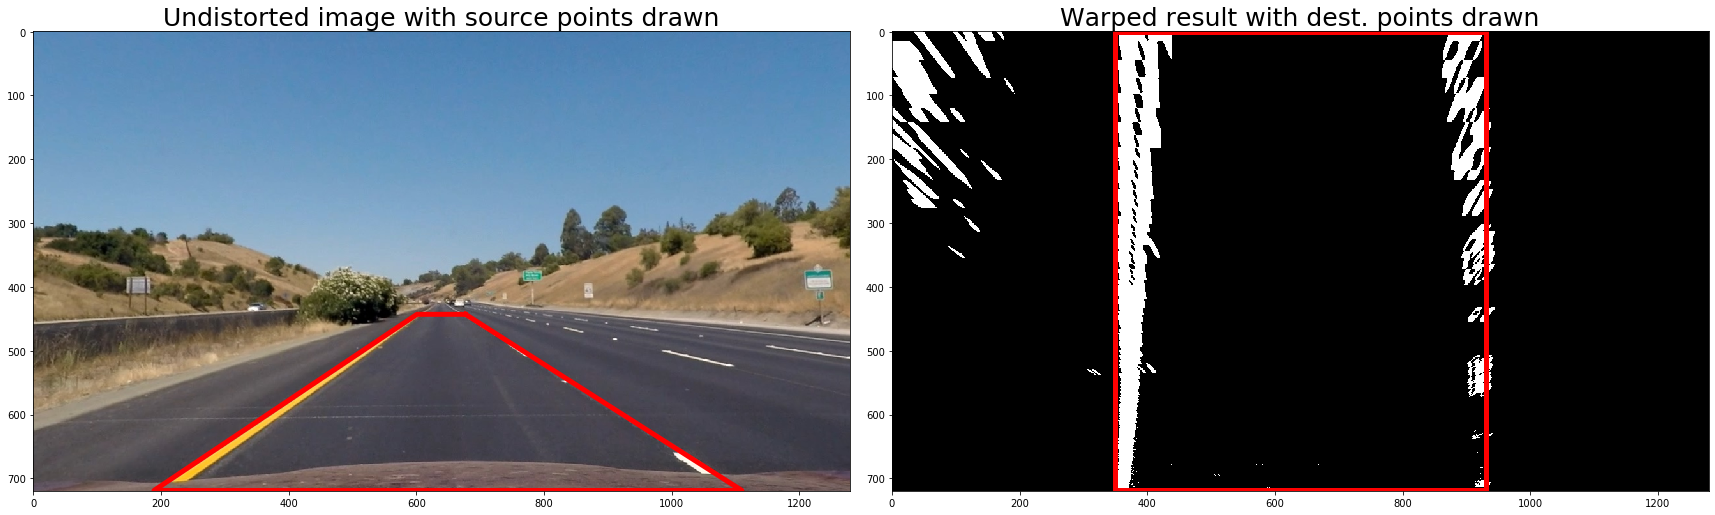

In [12]:
%matplotlib inline

undist, top_down, M, Minv = warper('./test_images/straight_lines1.jpg', src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
ax1.plot(np.append(src[:, 0], src[0, 0]), np.append(src[:, 1], src[0, 1]), 
         '-', c='red', linewidth=5)
ax1.set_title('Undistorted image with source points drawn', fontsize=25)
ax2.imshow(top_down, cmap='gray')
ax2.plot(np.append(dst[:, 0], dst[0, 0]), np.append(dst[:, 1], dst[0, 1]), 
         '-', c='red', linewidth=5)
ax2.set_title('Warped result with dest. points drawn', fontsize=25)

Text(0.5, 1, 'Warped result with dest. points drawn')

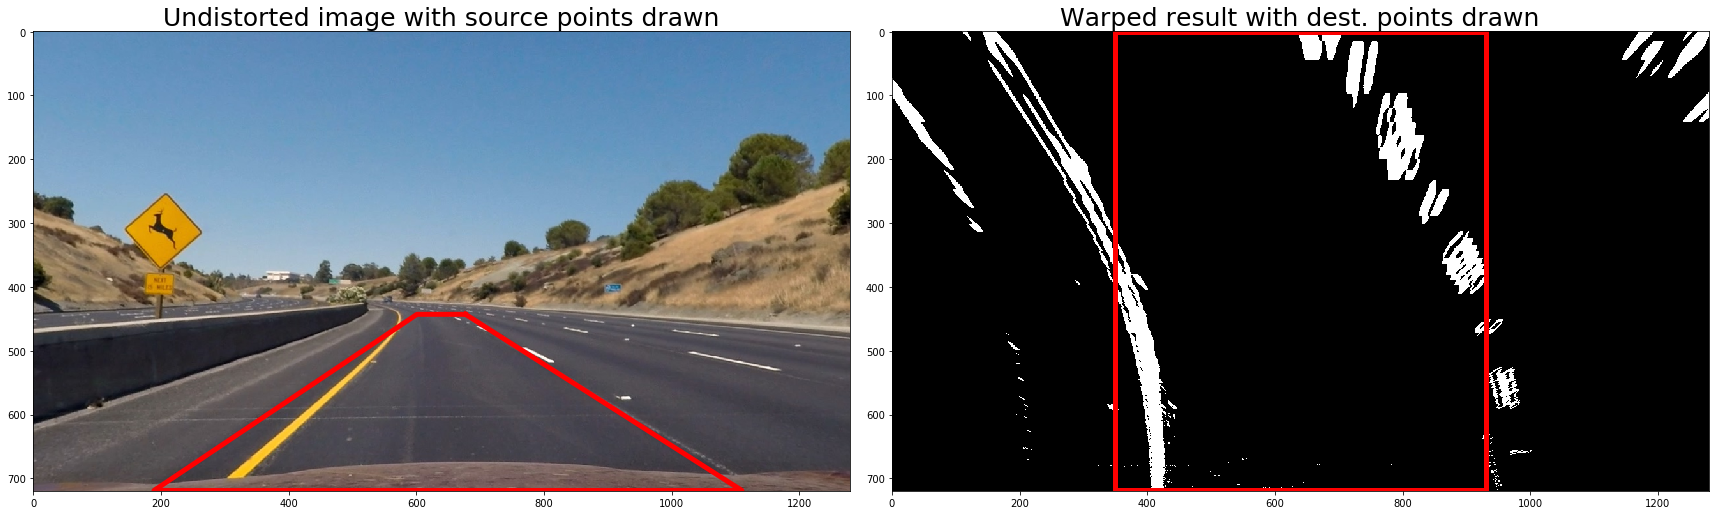

In [13]:
# For curved lines
img = cv2.imread('./test_images/test2.jpg')

# Use the OpenCV undistort() function to remove distortion
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Use color transforms, gradients, etc., to create a thresholded binary image
color_binary, combined_binary = create_thresholded_binary(undist)

# Warp the image using the perspective transform matrix
top_down = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
ax1.plot(np.append(src[:, 0], src[0, 0]), np.append(src[:, 1], src[0, 1]), 
         '-', c='red', linewidth=5)
ax1.set_title('Undistorted image with source points drawn', fontsize=25)
ax2.imshow(top_down, cmap='gray')
ax2.plot(np.append(dst[:, 0], dst[0, 0]), np.append(dst[:, 1], dst[0, 1]), 
         '-', c='red', linewidth=5)
ax2.set_title('Warped result with dest. points drawn', fontsize=25)

## Detect lane pixels and fit to find the lane boundary.

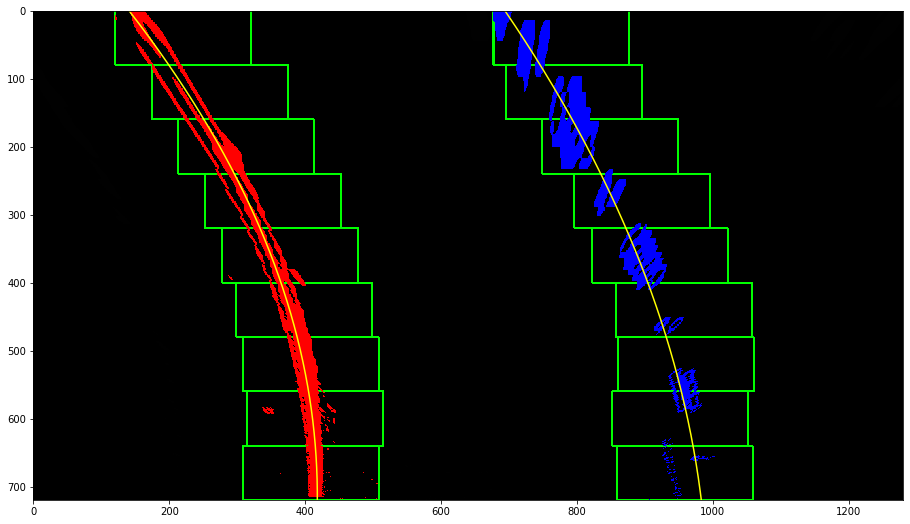

In [15]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        leftx_previous = leftx_current
        rightx_previous = rightx_current
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        left_delta = abs(leftx_current - leftx_previous)
        right_delta = abs(rightx_current - rightx_previous)
        
        ### If the left window is recentered but the right window is not
        ### recenter the right with the same delta as the left, and vice versa
        if left_delta != 0 and right_delta == 0:
            rightx_current = rightx_previous + left_delta
        if left_delta == 0 and right_delta != 0:
            leftx_current = leftx_previous + right_delta
        
        ### Prevent abrupt change in one of the two window centers
        delta_threshold = 50
        if abs(right_delta - left_delta) > delta_threshold:
            leftx_current = leftx_previous + min(left_delta, right_delta)
            rightx_current = rightx_previous + min(left_delta, right_delta)
            

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
#     print(left_fit)
#     print(right_fit)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return ploty, left_fitx, right_fitx, out_img

ploty, left_fitx, right_fitx, out_img = fit_polynomial(top_down)

# Plots the left and right polynomials on the lane lines
plt.figure(figsize=(16, 9))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

## Determine the curvature of the lane and vehicle position with respect to center.

In [12]:
def measure_curvature_real(ploty, left_fitx, right_fitx):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/580 # meters per pixel in x dimension
    
    # Fit a second order polynomial to pixel positions in each lane line
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [13]:
# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real(ploty, left_fitx, right_fitx)

print(left_curverad, 'm', right_curverad, 'm')

250.47633724674714 m 351.10835550925935 m


In [14]:
def measure_vehicle_position(left_fitx, right_fitx):
    '''
    Calculates the vehicle position with respect to center in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/580 # meters per pixel in x dimension
    
    # Assume the camera is mounted at the center of the car
    image_center = 1280 // 2
    
    # Use the bottom one fifth of the image to locate car center
    mean_left = np.mean(left_fitx[-left_fitx.shape[0] // 5:])
    mean_right = np.mean(right_fitx[-right_fitx.shape[0] // 5:])
    lane_center = (mean_right + mean_left) / 2
    
    line_base_pos = (lane_center - image_center) * xm_per_pix
        
    return line_base_pos

In [15]:
line_base_pos = measure_vehicle_position(left_fitx, right_fitx)

side = 'left' if line_base_pos > 0 else 'right'
print(side, ' ', line_base_pos, 'm')

left   0.33767783181706856 m


## Warp the detected lane boundaries back onto the original image.

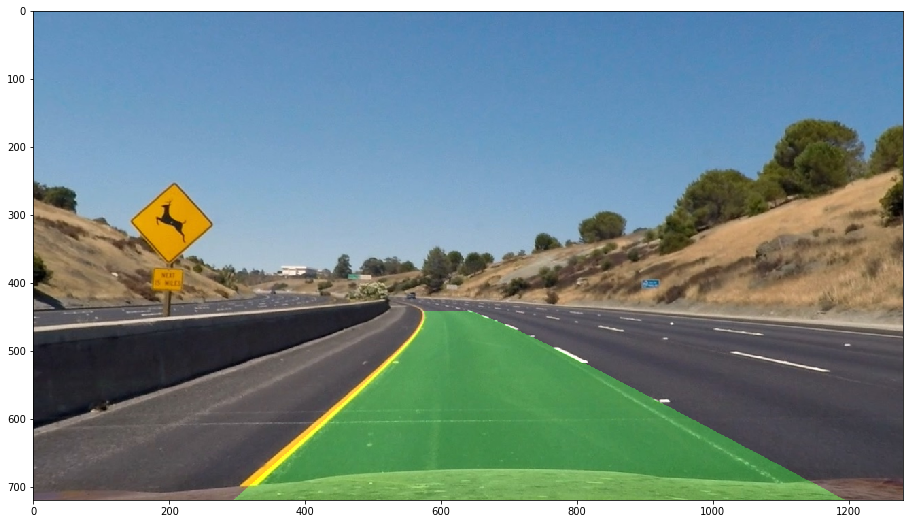

In [16]:
def warp_lane_boundaries(undist, ploty, left_fitx, right_fitx, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(top_down).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

result = warp_lane_boundaries(undist, ploty, left_fitx, right_fitx, Minv)

plt.figure(figsize=(16, 9))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

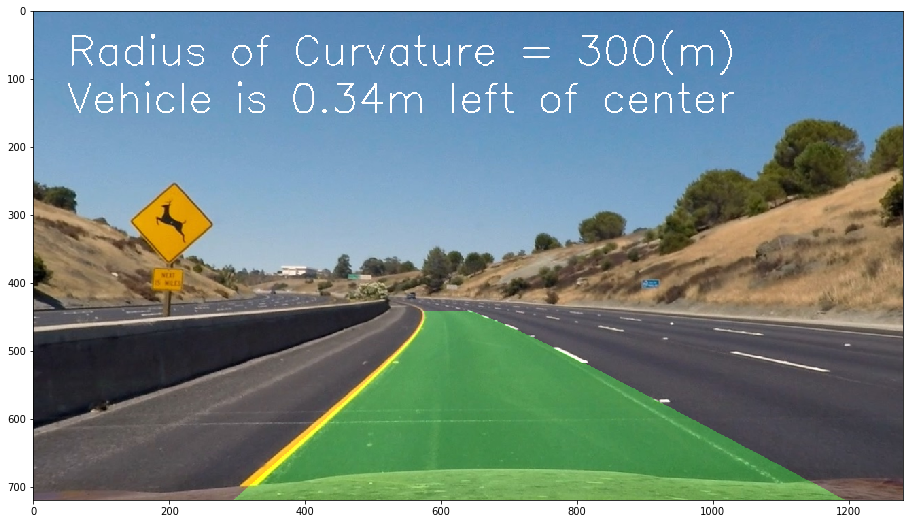

In [17]:
def put_text(image, left_curverad, right_curverad, line_base_pos):
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = 2
    fontColor              = (255,255,255)
    lineType               = 2

    curvature = int((left_curverad + right_curverad) / 2)
    
    if curvature > 10000:
        cv2.putText(image, f'Radius of Curvature = inf', 
        (50, 80), 
        font, 
        fontScale,
        fontColor,
        lineType)
    else:
        cv2.putText(image, f'Radius of Curvature = {curvature}(m)', 
            (50, 80), 
            font, 
            fontScale,
            fontColor,
            lineType)
        
    
    side = 'left' if line_base_pos > 0 else 'right'

    cv2.putText(image, f'Vehicle is {abs(line_base_pos):.2f}m {side} of center', 
        (50, 150), 
        font, 
        fontScale,
        fontColor,
        lineType)
    
    return image

result_with_text = put_text(result, left_curverad, right_curverad, line_base_pos)

plt.figure(figsize=(16, 9))
plt.imshow(cv2.cvtColor(result_with_text, cv2.COLOR_BGR2RGB))

## Image Pipeline

In [18]:
def find_lane_advanced_image(image):
    # Load image
    img = cv2.imread(image)
    
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    # Use color transforms, gradients, etc., to create a thresholded binary image
    color_binary, combined_binary = create_thresholded_binary(undist)
    
    # Warp the image using the perspective transform matrix
    top_down = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)
    
    ploty, left_fitx, right_fitx, out_img = fit_polynomial(top_down)
    
    left_curverad, right_curverad = measure_curvature_real(ploty, left_fitx, right_fitx)
    
    line_base_pos = measure_vehicle_position(left_fitx, right_fitx)
    
    result = warp_lane_boundaries(undist, ploty, left_fitx, right_fitx, Minv)
    
    result_with_text = put_text(result, left_curverad, right_curverad, line_base_pos)
    
    return result_with_text

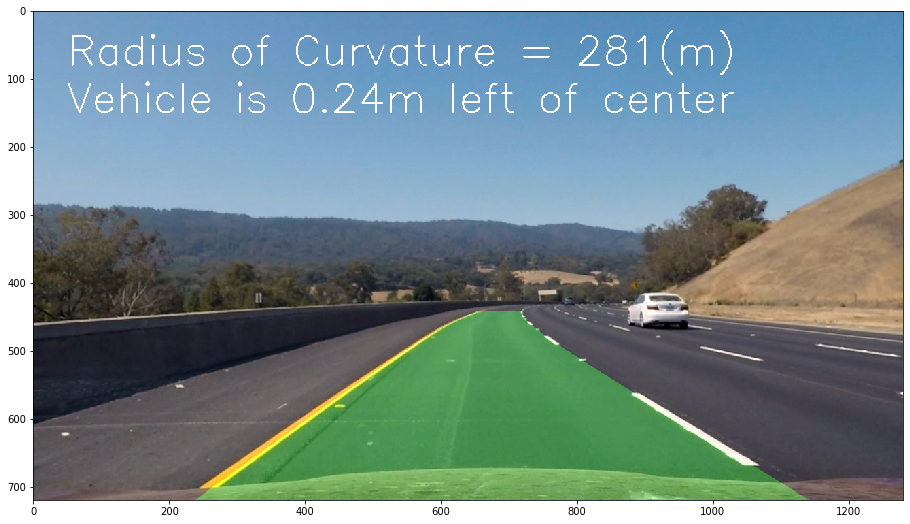

In [19]:
res = find_lane_advanced_image('./test_images/test3.jpg')
plt.figure(figsize=(16, 9))
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))

## Test on Videos with Tracking

### Modify Some Functions for Video Processing

In [20]:
def create_thresholded_binary_video(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 175
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    # Get mask roi
    img_size = (combined_binary.shape[1], combined_binary.shape[0]) # grab the image shape
    vertices = np.array([[(0, img_size[1]), 
                          (img_size[0] // 2 - 50, img_size[1] // 2 + 60), 
                          (img_size[0] // 2 + 50, img_size[1] // 2 + 60),
                          (img_size[0], img_size[1])]], dtype=np.int32)
    combined_binary = region_of_interest(combined_binary, vertices)
    
    return combined_binary

In [21]:
def find_lane_pixels_video(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        leftx_previous = leftx_current
        rightx_previous = rightx_current
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        left_delta = abs(leftx_current - leftx_previous)
        right_delta = abs(rightx_current - rightx_previous)
        
        ### If the left window is recentered but the right window is not
        ### recenter the right with the same delta as the left, and vice versa
        if left_delta != 0 and right_delta == 0:
            rightx_current = rightx_previous + left_delta
        if left_delta == 0 and right_delta != 0:
            leftx_current = leftx_previous + right_delta
        
        ### Prevent abrupt change in one of the two window centers
        delta_threshold = 50
        if abs(right_delta - left_delta) > delta_threshold:
            leftx_current = leftx_previous + min(left_delta, right_delta)
            rightx_current = rightx_previous + min(left_delta, right_delta)
            

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


def fit_polynomial_video(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty = find_lane_pixels_video(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
#     print(left_fit)
#     print(right_fit)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        detected = True
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        detected = False

    return detected, ploty, left_fitx, right_fitx, left_fit, right_fit

### Define Line() Class

In [22]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients of the last n fits of the line
        self.recent_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 

### Pipeline for Video Processing

In [24]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from copy import deepcopy

In [56]:
def find_lane_advanced_video(video):
    # Load video
    print(f"Loading video...", end='\r', flush=False)
    clip1 = VideoFileClip(video)
    frames = list(clip1.iter_frames())
    n_frames = len(frames)    
    
    # Set parameters
    n_track = 15
    xm_per_pix = 3.7/580
    lane_width_diff_threshold = 0.25
    frames_result = []

    left_line_prev = Line()
    right_line_prev = Line()

    for i, frame_cur in enumerate(frames):

        left_line_cur = deepcopy(left_line_prev)
        right_line_cur = deepcopy(right_line_prev)

        # Use the OpenCV undistort() function to remove distortion
        undist = cv2.undistort(frame_cur, mtx, dist, None, mtx)
        # Use color transforms, gradients, etc., to create a thresholded binary image
        combined_binary = create_thresholded_binary_video(undist)
        # Warp the image using the perspective transform matrix
        top_down = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)

        detected, ploty, left_fitx, right_fitx, left_fit, right_fit = fit_polynomial_video(top_down)

        left_line_cur.detected = detected

        if i <= n_track:
            left_line_cur.recent_xfitted.append(left_fitx)
            right_line_cur.recent_xfitted.append(right_fitx)

            left_line_cur.bestx = np.mean(left_line_cur.recent_xfitted, axis = 0)
            right_line_cur.bestx = np.mean(right_line_cur.recent_xfitted, axis = 0)
            left_line_cur.best_fit = np.mean(left_line_cur.recent_fit, axis = 0)
            right_line_cur.best_fit = np.mean(right_line_cur.recent_fit, axis = 0)
        else:

            # Check lane width
            lane_width_cur = np.mean(right_fitx - left_fitx) * xm_per_pix
            lane_width_best = np.mean(right_line_cur.bestx - left_line_cur.bestx) * xm_per_pix
            if abs(lane_width_cur - lane_width_best) < lane_width_diff_threshold:

                left_line_cur.recent_xfitted.pop(0)
                right_line_cur.recent_xfitted.pop(0)
                left_line_cur.recent_fit.pop(0)
                right_line_cur.recent_fit.pop(0)

                left_line_cur.recent_xfitted.append(left_fitx)
                right_line_cur.recent_xfitted.append(right_fitx)
                left_line_cur.recent_fit.append(left_fit)
                right_line_cur.recent_fit.append(right_fit)
                
                # Smoothing
                left_line_cur.bestx = np.mean(left_line_cur.recent_xfitted, axis = 0)
                right_line_cur.bestx = np.mean(right_line_cur.recent_xfitted, axis = 0)
                left_line_cur.best_fit = np.mean(left_line_cur.recent_fit, axis = 0)
                right_line_cur.best_fit = np.mean(right_line_cur.recent_fit, axis = 0)


        # Measure radius curvature of the line and distance in meters of vehicle center from the line
        left_curverad, right_curverad = measure_curvature_real(ploty, left_line_cur.bestx, right_line_cur.bestx)
        line_base_pos = measure_vehicle_position(left_line_cur.bestx, right_line_cur.bestx)

        left_line_cur.radius_of_curvature = left_curverad
        right_line_cur.radius_of_curvature = right_curverad
        left_line_cur.line_base_pos = line_base_pos
        right_line_cur.line_base_pos = line_base_pos


        # Warp the detected lane boundaries back into image
        result = warp_lane_boundaries(undist, ploty, left_line_cur.bestx, right_line_cur.bestx, Minv)
        result_with_text = put_text(result, left_curverad, right_curverad, line_base_pos)

        left_line_prev = deepcopy(left_line_cur)
        right_line_prev = deepcopy(right_line_cur)

        frames_result.append(result_with_text)

        print(f"Processing frame {i}", end='\r', flush=False)
    
    return frames_result

In [57]:
def generate_video(frames, video):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Be sure to use lower case
    out = cv2.VideoWriter(video, fourcc, clip1.fps, img_size)
    for i, frame_result in enumerate(frames_result):

        out.write(cv2.cvtColor(frame_result, cv2.COLOR_BGR2RGB)) # Write out frame to video
        print(f"Writing frame {i}", end='\r', flush=True)

    # Release everything if job is finished
    out.release()

In [59]:
frames_result = find_lane_advanced_video("./project_video.mp4")
generate_video(frames_result, "./videos_output/project_video_result.mp4")